# 3 - Pré-processamento

## 3.1 - Baixando e importando dados

In [1]:
!gdown --id 1iwTU12iQhT8kPPMcG9z06OvL1IJdINFv

Downloading...
From: https://drive.google.com/uc?id=1iwTU12iQhT8kPPMcG9z06OvL1IJdINFv
To: /content/train.csv.zip
1.67GB [00:10, 153MB/s]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
tqdm.pandas()

from sklearn.model_selection import train_test_split

from toolz import curry

In [3]:
df = pd.read_csv('train.csv.zip', compression='zip', nrows=5000000,
                   error_bad_lines=False)#.drop(columns='key')

df['anomes'] = df.progress_apply(lambda x: int(x.pickup_datetime[:4]+x.pickup_datetime[5:7]), axis = 1)

100%|██████████| 5000000/5000000 [02:14<00:00, 37038.60it/s]


In [4]:
df['anomes'].max()

201506

**Validação out of time**: Vamos separar 201407 até 201506 inteiro para ser a nossa validação final. Enquanto treinamos com os dados de 201209 (como discutido anteriormente) até 201406.

In [5]:
 df_train, df_test, _, _ = train_test_split(df, df.index, test_size=0.2, random_state=42)

df_train = df_train.query("201406>=anomes>=201209").reset_index(drop=True)
df_test = df_test.query("anomes>=201407").reset_index(drop=True)

In [6]:
df_train.shape, df_test.shape

((1140518, 9), (141336, 9))

In [7]:
def date_vars(df):
  df_aux = df.copy()
  print('6 barras')

  df_aux['pickup_datetime'] = df_aux.progress_apply(lambda x: pd.to_datetime(x.pickup_datetime), axis=1)
  df_aux['weekday'] = df_aux.progress_apply(lambda x: x.pickup_datetime.day, axis=1)
  df_aux['year'] = df_aux.progress_apply(lambda x: x.pickup_datetime.year, axis=1)
  df_aux['month'] = df_aux.progress_apply(lambda x: x.pickup_datetime.month, axis=1)
  df_aux['time'] = df_aux.progress_apply(lambda x: x.pickup_datetime.hour*60 + x.pickup_datetime.minute, axis=1)
  df_aux['weekofyear'] = df_aux.progress_apply(lambda x: x.pickup_datetime.weekofyear, axis=1)

  return df_aux

In [8]:
df_train = date_vars(df_train)

6 barras


100%|██████████| 1140518/1140518 [00:22<00:00, 51201.21it/s]


In [9]:
df_test = date_vars(df_test)

6 barras


100%|██████████| 141336/141336 [00:02<00:00, 51709.66it/s]


## 3.2 - Processamento das latitudes/longitudes

Aqui vamos aplicar as manipulações discutidas no primeiro notebook.

In [10]:
@curry
def swap_long_lat(df, coluna, coluna_swap, lim_inf, lim_sup):

  df_aux1 = df.query(f"{lim_inf}<{coluna}<{lim_sup} or {coluna}==0")
  
  df_aux2 = df.query(f"(not ({lim_inf}<{coluna}<{lim_sup})) and {coluna}!=0")
  i = df_aux2.columns.to_list()
  a, b = i.index(coluna), i.index(coluna_swap)
  i[b], i[a] = i[a], i[b]
  df_aux2.columns = i

  df_aux3 = df_aux2.query(f"{lim_inf}<{coluna}<{lim_sup}")
  
  df_aux4 = df_aux2.query(f"not({lim_inf}<{coluna}<{lim_sup})")
  i = df_aux4.columns.to_list()
  a, b = i.index(coluna), i.index(coluna_swap)
  i[b], i[a] = i[a], i[b]
  df_aux4.columns = i

  return pd.concat([df_aux1, df_aux3, df_aux4])

@curry
def flag_erro(df, lim_inf_lat, lim_sup_lat, lim_inf_long, lim_sup_long):
  df_aux = df.copy()
  query = " or ".join([f"(not({lim_inf_long}<{col}<{lim_sup_long}))" for col in ['pickup_longitude', 'dropoff_longitude']]
                      + [f"(not({lim_inf_lat}<{col}<{lim_sup_lat}))" for col in ['pickup_latitude', 'dropoff_latitude']])
  df_aux['flag_error'] = 0
  df_aux.loc[df_aux.query(query).index, 'flag_error'] = 1
  return df_aux

@curry
def fill_error(df, coluna, lim_inf, lim_sup):
  df_aux = df.copy()
  df_aux.loc[df_aux.query(f"(not({lim_inf}<{coluna}<{lim_sup}))").index, coluna] = np.nan
  return df_aux.fillna(dict(df_aux[[coluna]].median()))

In [11]:
def preprocess_latlong(df, lim_inf_lat, lim_sup_lat, lim_inf_long, lim_sup_long):
  return (df
          .fillna(0)
          .pipe(swap_long_lat(coluna='pickup_longitude', coluna_swap='pickup_latitude', lim_inf=lim_inf_long, lim_sup=lim_sup_long))
          .pipe(swap_long_lat(coluna='pickup_latitude', coluna_swap='pickup_longitude', lim_inf=lim_inf_lat, lim_sup=lim_sup_lat))
          .pipe(swap_long_lat(coluna='dropoff_longitude', coluna_swap='dropoff_latitude', lim_inf=lim_inf_long, lim_sup=lim_sup_long))
          .pipe(swap_long_lat(coluna='dropoff_latitude', coluna_swap='dropoff_longitude', lim_inf=lim_inf_lat, lim_sup=lim_sup_lat))
          .pipe(flag_erro(lim_inf_lat=lim_inf_lat, lim_sup_lat=lim_sup_lat, lim_inf_long=lim_inf_long, lim_sup_long=lim_sup_long))
          .pipe(fill_error(coluna='pickup_longitude', lim_inf=lim_inf_long, lim_sup=lim_sup_long))
          .pipe(fill_error(coluna='pickup_latitude', lim_inf=lim_inf_lat, lim_sup=lim_sup_lat))
          .pipe(fill_error(coluna='dropoff_longitude', lim_inf=lim_inf_long, lim_sup=lim_sup_long))
          .pipe(fill_error(coluna='dropoff_latitude', lim_inf=lim_inf_lat, lim_sup=lim_sup_lat))
          )

In [12]:
%%time

# limites de latitudes/longitudes que vamos tolerar
lim_inf_lat, lim_sup_lat =     39, 42  #  40.3,  41.2
lim_inf_long, lim_sup_long = -76, -72  # -74.3, -73.5

df_train = preprocess_latlong(df_train, lim_inf_lat, lim_sup_lat, lim_inf_long, lim_sup_long)

df_test = preprocess_latlong(df_test, lim_inf_lat, lim_sup_lat, lim_inf_long, lim_sup_long)

CPU times: user 10.8 s, sys: 103 ms, total: 10.9 s
Wall time: 10.7 s


In [13]:
df_train.flag_error.sum()

21821

In [14]:
df_train.shape[0]

1140518

## 3.3 - Criando variável de distância entre pickup e dropoff

In [95]:
# df_train.fillna(0, inplace=True)
# df_test.fillna(0, inplace=True)

# lat_long_cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
# for col in lat_long_cols:
#   df_train[col] = df_train[col].clip(-89, 89)
#   df_test[col] = df_test[col].clip(-89, 89)

In [15]:
# função que, dada latitude/longitude de dois pontos calcula a distância entre eles
from geopy.distance import distance

distance((df_train.iloc[0].pickup_latitude, df_train.iloc[0].pickup_longitude), (df_train.iloc[0].dropoff_latitude, df_train.iloc[0].dropoff_longitude)).km

5.122833365107197

In [16]:
distance((df_train.iloc[0].dropoff_latitude, df_train.iloc[0].dropoff_longitude), (df_train.iloc[0].pickup_latitude, df_train.iloc[0].pickup_longitude)).km

5.122833365107197

In [17]:
df_train['distance'] = df_train.progress_apply(lambda x: distance((x.pickup_latitude, x.pickup_longitude), (x.dropoff_latitude, x.dropoff_longitude)).km, axis=1)

100%|██████████| 1140518/1140518 [06:14<00:00, 3047.84it/s]


In [18]:
df_test['distance'] = df_test.progress_apply(lambda x: distance((x.pickup_latitude, x.pickup_longitude), (x.dropoff_latitude, x.dropoff_longitude)).km, axis=1)

100%|██████████| 141336/141336 [00:46<00:00, 3040.93it/s]


In [19]:
df_train['distance'].describe(percentiles=[0.1, 0.25, 0.75, 0.99])

count    1.140518e+06
mean     3.344483e+00
std      3.754549e+00
min      0.000000e+00
10%      7.429178e-01
25%      1.233960e+00
50%      2.148691e+00
75%      3.936585e+00
99%      2.047305e+01
max      1.753160e+02
Name: distance, dtype: float64

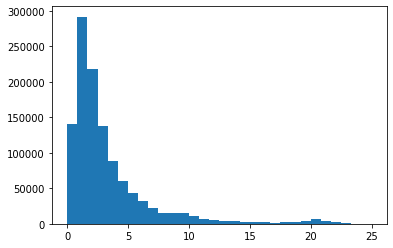

In [20]:
plt.hist(df_train.query('distance<25')['distance'], bins =30)
plt.show()

## 3.4 - Criando a variável de CEP a partir da API do geopy

Para mais detalhes, olhar o notebook de apêndice.

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

class filling_zipcode:
  
  def __init__(self):
    self.geocode = RateLimiter(Nominatim(user_agent='serasa_datalab_case').reverse, min_delay_seconds=0.1)

  def fun(self, row):
    return ' , '.join(row[['pickup_latitude','pickup_longitude']].apply(lambda x: np.round(x, decimals=6)).astype(str).to_list())

  def try_except(self, loc, info):
    try:
      return loc['address'][info]
    except:
      return "NaN"

  def geolocar(self, x):
    infos = ['suburb', 'postcode']
    if x['pickup_latitude'] != 0 and x['pickup_longitude'] != 0 :
      loc = self.geocode(x['api']).raw
      return [self.try_except(loc, info) for info in infos]
    else:
      return ['NaN' for info in infos]


  def consulta_fit(self, df, n_consultas=1000, frequencia_min=20):

    df_aux = df.head(n_consultas).copy()
    df_aux['api'] = df_aux.apply(self.fun, axis=1)

    df_aux['response_api'] = df_aux.progress_apply(self.geolocar, axis=1)

    df_aux['suburb'] = df_aux.apply(lambda x: x['response_api'][0], axis=1)
    df_aux['postcode'] = df_aux.apply(lambda x: x['response_api'][1][:5], axis=1)

    counts = df_aux.postcode.value_counts()
    repl = counts[counts < frequencia_min].index
    df_aux['postcode'] = df_aux['postcode'].replace(repl, '10000')

    X = df_aux[['pickup_latitude','pickup_longitude']]
    y = df_aux['postcode']

    self.knn = KNeighborsClassifier(n_neighbors=1).fit(X, y)

  def predict(self, df):
    df_aux = df.copy()
    df_aux['pickup_zipcode'] = self.knn.predict(df_aux[['pickup_latitude','pickup_longitude']])
    df_aux['dropoff_zipcode'] = self.knn.predict(df_aux[['dropoff_latitude','dropoff_longitude']])
    return df_aux

In [22]:
preenchedor = filling_zipcode()
preenchedor.consulta_fit(df_train, 1000, 30)

100%|██████████| 1000/1000 [16:17<00:00,  1.02it/s]


In [23]:
%%time
df_train = preenchedor.predict(df_train)

CPU times: user 1min 19s, sys: 4.29 s, total: 1min 23s
Wall time: 1min 19s


In [24]:
%%time
df_test = preenchedor.predict(df_test)

CPU times: user 10.3 s, sys: 724 ms, total: 11.1 s
Wall time: 10.3 s


In [27]:
# df_train_backup = df_train.copy()
# df_test_backup = df_test.copy()

# df_train = df_train_backup.copy()
# df_test = df_test_backup.copy()

## 3.5 - Dando um get_dummies na variável de CEP

In [ ]:
# pip install category_encoders

In [28]:
%%time

from category_encoders.one_hot import OneHotEncoder
enc = OneHotEncoder(cols=['pickup_zipcode', 'dropoff_zipcode'], use_cat_names=True)

df_train = enc.fit_transform(df_train)
df_test = enc.transform(df_test)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


CPU times: user 5.02 s, sys: 800 ms, total: 5.82 s
Wall time: 5.57 s


## 3.6 Modelagem

In [29]:
from lightgbm import LGBMRegressor
# import xgboost as xgb
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error

In [30]:
df_train.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'anomes', 'weekday', 'year', 'month', 'time',
       'weekofyear', 'flag_error', 'distance', 'pickup_zipcode_10000',
       'pickup_zipcode_10019', 'pickup_zipcode_10001', 'pickup_zipcode_10021',
       'pickup_zipcode_10011', 'pickup_zipcode_10022', 'pickup_zipcode_10018',
       'pickup_zipcode_10016', 'pickup_zipcode_10017', 'pickup_zipcode_10036',
       'pickup_zipcode_10024', 'pickup_zipcode_10003', 'dropoff_zipcode_10000',
       'dropoff_zipcode_10022', 'dropoff_zipcode_10019',
       'dropoff_zipcode_10016', 'dropoff_zipcode_10017',
       'dropoff_zipcode_10021', 'dropoff_zipcode_10011',
       'dropoff_zipcode_10024', 'dropoff_zipcode_10036',
       'dropoff_zipcode_10003', 'dropoff_zipcode_10018',
       'dropoff_zipcode_10001'],
      dtype='object')

In [31]:
var_cols = ['pickup_longitude', 'pickup_latitude',
            'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 
             'flag_error', 'distance'] #,
       
zipcode_cols = [col for col in df_train.columns if 'zipcode' in col]

time_cols = ['weekday', 'time']

vars = var_cols  + time_cols + zipcode_cols

In [58]:
lgbm = LGBMRegressor(random_state=0)
# cross validate sem visão temporal
pd.DataFrame(cross_validate(lgbm, df_train[vars], df_train['fare_amount'], scoring='neg_mean_absolute_error')).apply(lambda x: np.sqrt(-np.mean(x))).test_score

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


1.4644769240347495

In [33]:
lgbm.fit(df_train[vars], df_train['fare_amount'])

(pd.DataFrame(lgbm.booster_.feature_importance(importance_type='gain'), 
              index=vars, columns=['feature_importances'])
.sort_values(by='feature_importances', ascending=False)
).head(10)

,feature_importances
distance,5.361651e+08
dropoff_longitude,2.593786e+07
dropoff_latitude,1.104476e+07
pickup_longitude,7.305666e+06
time,4.107030e+06
pickup_latitude,3.372655e+06
flag_error,1.509890e+06
weekday,5.986203e+05
passenger_count,1.971323e+05
pickup_zipcode_10000,6.447051e+04


In [34]:
mean_absolute_error(df_test['fare_amount'], lgbm.predict(df_test[vars]))

2.1201447619541702

# 3.7 Otimização Bayesiana de hiperparâmetros

In [81]:
# pip install scikit-optimize

In [36]:
from skopt import gp_minimize
from sklearn.model_selection import TimeSeriesSplit

In [37]:
df_train = df_train.sort_values(by=['key'])

In [44]:
# baseado no código do mario filho: https://github.com/ledmaster/notebooks_tutoriais/blob/master/como_tunar_hipers.ipynb

def treinar_modelo(params):
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    max_depth = int(params[5])
    n_estimators = params[6]

    print(params)

    mdl = LGBMRegressor(learning_rate=learning_rate, num_leaves=num_leaves, min_child_samples=min_child_samples,
                        max_depth=max_depth, 
                        subsample=subsample, colsample_bytree=colsample_bytree, random_state=0, subsample_freq=1, 
                         n_estimators=n_estimators)
    
    tss = TimeSeriesSplit(n_splits=5)
    cv = cross_validate(mdl, df_train[vars], df_train['fare_amount'], cv=tss, scoring='neg_mean_absolute_error', return_train_score=True)
    
    print(-cv['train_score'].mean(), -cv['test_score'].mean(), '\n')
    if abs(cv['train_score'].mean() - cv['test_score'].mean())<0.3:
      return -cv['test_score'].mean()
    else:
      return -cv['test_score'].mean()

space = [(1e-3, 3e-1, 'log-uniform'), #learning rate
         (10, 2000), # num_leaves
         (1, 500), # min_child_samples
         (0.05, 1.0), # subsample
         (0.1, 1.0), # colsample bytree
         (2, 15), # max_depth
         (100, 800) # n_estimators
         ]
         
# [0.14034271283097055, 289, 500, 1.0, 1.0, 15, 70, 53, 723]

In [45]:
resultados_gp = gp_minimize(treinar_modelo, space, random_state=100, verbose=1, n_calls=50, n_random_starts=10)

Iteration No: 1 started. Evaluating function at random point.
[0.04597628595236971, 830, 264, 0.19117459807159687, 0.24103997207740102, 4, 247]
2.4379519632684703 2.4533788691808596 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 39.8804
Function value obtained: 2.4534
Current minimum: 2.4534
Iteration No: 2 started. Evaluating function at random point.
[0.01322792233052441, 1742, 33, 0.6430962938721628, 0.5710129698127167, 9, 104]
3.2634631487846684 3.3054798254261164 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 44.0836
Function value obtained: 3.3055
Current minimum: 2.4534
Iteration No: 3 started. Evaluating function at random point.
[0.005774635432900128, 1901, 64, 0.1250384790853672, 0.3802178207536516, 10, 590]
2.5323091653158256 2.5659050918018282 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 259.4113
Function value obtained: 2.5659
Current minimum: 2.4534
Iteration No: 4 started. Evaluating function at rando

In [46]:
resultados_gp.x
# [0.14034271283097055, 289, 500, 1.0, 1.0, 15, 70, 53, 723]

[0.04357969983057871, 2000, 120, 1.0, 0.8940996444546291, 15, 736]

In [47]:
from skopt.plots import plot_convergence

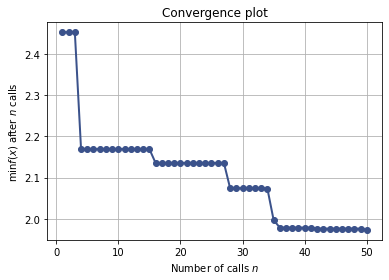

In [48]:
plot_convergence(resultados_gp)
plt.show()

In [51]:
def treinar_modelo_final(params):
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    max_depth = int(params[5])
    n_estimators = params[6]

    print(params)

    mdl = LGBMRegressor(learning_rate=learning_rate, num_leaves=num_leaves, min_child_samples=min_child_samples,
                        max_depth=max_depth, 
                        subsample=subsample, colsample_bytree=colsample_bytree, random_state=0, subsample_freq=1, 
                         n_estimators=n_estimators)
    
    mdl.fit(df_train[vars], df_train['fare_amount'])
    
    return mdl

In [52]:
model = treinar_modelo_final(resultados_gp.x)

[0.04357969983057871, 2000, 120, 1.0, 0.8940996444546291, 15, 736]


In [53]:
model

LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.8940996444546291, importance_type='split',
              learning_rate=0.04357969983057871, max_depth=15,
              min_child_samples=120, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=736, n_jobs=-1, num_leaves=2000, objective=None,
              random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=1)

In [54]:
mean_absolute_error(df_test['fare_amount'], model.predict(df_test[vars]))

1.922034383347082

In [55]:
# R^2 utilizando MAE no lugar do MSE

1 - mean_absolute_error(df_test['fare_amount'], model.predict(df_test[vars]))/(mean_absolute_error(df_test['fare_amount'], [df_test['fare_amount'].median()]*df_test.shape[0]))

0.7031666551736229

to dos:

- quais hiperparâmetros são mais importantes? modelo com entrada hiperparametros e previsao métrica. refinar o espaço de busca um pouco.

- SHAP

In [ ]:
import shap

shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_train[vars])

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], df_train[vars].iloc[0,:])